# Using Accelerometer Data to Detect Parkinson’s Disease: A Preliminary Study
<i>Simon Mercer -- Data Science Student, Galvanize, Inc., March 2017</i>

Refer to <strong>README.md</strong> in the root directory of this Git repository for full details of this analysis.

First, import Python modules:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
import sqlalchemy
from matplotlib import pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from IPython.core import display as ICD


/Users/sjm/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Import custom helper functions (see src/python/notebook_funcs.py) and notebook-specific display settings.

In [2]:
from src.python import notebook_funcs as nb
%matplotlib inline
sns.set()

Connect to the local PostgreSQL instance, database name <strong>'tremor'</strong>, compile a list of gesture names, and retrieve one data frame per gesture.

In [3]:
conn = nb.connect('tremor')

# prepare a list of gesture names in the order they are processed
gestures = ['Lap Left', 'Lap Right', 'Nose Left', 'Nose Right', 'Shoulder Left', 'Shoulder Right']

# get all gesture data
all_gesture_dfs = nb.get_datasets(conn)

This pipeline function is not located in the helper functions because of its importance here - this is the <strong>logistic regression pipeline</strong>, including standardization preprocessing and adjustable Lasso regularization: hyperparameters may be (further) tweaked to improve regression performance.

In [4]:
def make_pipe(reg=1000):
    # logistic regression hyperparameters
    lr_penalty = 'l1' # l1=lasso, l2=ridge
    lr_C = reg # C=1000 suppresses regularization, default is C=1.0
    lr_class_weight = 'balanced' # automatically adjust weights inversely proportional to class frequencies
    lr_max_iter = 100 # insensitive between 50 and 10000 - leave
    lr_solver = 'liblinear' # best solver for this problem
    lr_tol = 0.0001

    # build a logistic regression pipeline with scaling and regularization
    lr_scaler = StandardScaler(with_mean=True, with_std=True)
    lr = LogisticRegression(
            penalty=lr_penalty,
            C=lr_C, 
            class_weight=lr_class_weight, 
            max_iter=lr_max_iter, 
            solver=lr_solver,
            tol=lr_tol)

    lr_pipeline = make_pipeline(lr_scaler, lr)
    return [lr_pipeline, lr]

Create and fit naive models to assess the predictive power of the dataset:
<ol>
<li> Determine the <strong>Null Error Rate</strong>, i.e., if we always predicted the majority class, how right would we be?
<li> Compare the Null Error Rate with a 10-fold cross-validation to see how much accuracy is due to the regression model
</ol>

In [5]:
num_folds = 10 # optimal or close to it
cv_all_feats = [] # store cross-validation scores here for comparison later

for i, gesture in enumerate(all_gesture_dfs):
    X, y = nb.create_predictor_set(gesture)
    
    if i == 0:
        # this will be the same for all six sets, so print for set 0
        ne_rate = pd.Series.sum(y)/float(pd.Series.count(y))
        print "Null error rate for all data sets is {}\n".format(ne_rate)
    
    # make a new pipeline for each gesture
    (my_pipe, my_lr) = make_pipe()

    # evaluate model accuracy using k-fold cross validation
    cv_probabilities = cross_val_score(my_pipe, X, y, cv=num_folds)
    mean_acc = np.mean(cv_probabilities)
    cv_all_feats.append(mean_acc)
    
# compare model with restricted feature sets
improvement_list = pd.DataFrame(
    {'Gesture': gestures,
    'All features': cv_all_feats,
    'Improvement over Null Error rate': [x - ne_rate for x in cv_all_feats]
})

print "Cross-validation (k={})".format(num_folds)
improvement_list[['Gesture', 'All features', 'Improvement over Null Error rate']]
    

Null error rate for all data sets is 0.518181818182

Cross-validation (k=10)


,Gesture,All features,Improvement over Null Error rate
0,Lap Left,0.699765,0.181583
1,Lap Right,0.715274,0.197092
2,Nose Left,0.667212,0.149031
3,Nose Right,0.676548,0.158366
4,Shoulder Left,0.632835,0.114653
5,Shoulder Right,0.650461,0.132279


Having conducted a naive analysis of the full dataset and determined that it has predictive value, we next seek to improve the predictive power of our regression through the selection of the most predictive features using the Sequential Floating Forward Selection algorithm.

<strong>NOTE - THIS STAGE IS VERY SLOW (> 2 HOURS ON A LAPTOP)</strong>

This produces lists of k selected features for each model where k=1 to 10, and graphs the increase in predictive power as each field is added. Note most of the predictive power is in the first field.

Experimentation with feature selection indicated that while accelerometer features alone are predictive, the best accuracy was obtained by a vector of gesture-specific accelerometer fields plus the age of the subject - see below.

In [ ]:
max_feats = 10

# the best feature set is the last one to increase accuracy
# over its predecessor of more than min_increment
min_increment = 0.001

for i, gesture in enumerate(all_gesture_dfs):

    print "Gesture {}".format(gestures[i])
    X, y = nb.create_predictor_set(gesture)
        
    # make a new pipeline for each gesture
    (my_pipe, my_lr) = make_pipe()
    
    (plot_x, plot_y) = nb.search_features(my_pipe, X, y, max_feats)
    print "Optimal feature set at k={}".format(nb.find_idx(plot_y, min_increment))  
            
    # graph to illustrate optimal number of features
    nb.sffs_plot(plot_x, plot_y)

For illustration, this is sample output from the previous stage for a single gesture. I choose the optimal feature set to be <i>the set with the fewest features such that the addition of any new feature will increase accuracy by less than min_increment</i> = 0.001:
<pre>
Gesture Lap Left
k=1, accuracy=0.816233766234, features(age)
k=2, accuracy=0.856371165067, features(age,iqrx)
k=3, accuracy=0.861133069829, features(age,iqrx,tlagz)
k=4, accuracy=0.861133069829, features(age,iqrx,tlagz,acfx)
k=5, accuracy=0.861133069829, features(age,iqrx,tlagz,acfx,cvx)
k=6, accuracy=0.861133069829, features(age,p0x,tlagz,iqrx,acfx,cvx)
k=7, accuracy=0.861133069829, features(age,p0x,tlagz,kury,iqrx,acfx,cvx)
k=8, accuracy=0.861547148504, features(age,p0x,tlagz,kury,q1aj,iqrx,acfx,cvx)
k=9, accuracy=0.865894974591, features(age,tlagz,tkeoy,iqrx,acfx,cvx,p0x,kury,q1aj)
k=10, accuracy=0.865894974591, features(age,tlagz,tkeoy,q1x,iqrx,acfx,cvx,p0x,kury,q1aj)
Optimal feature set at k=3
</pre>

The feature selection methodology above recommends the following feature sets - while these are good, they are not claimed to be optimal; examination of the SFFS output above shows accuracy can level off with additional features and then increase again due to feature interactions. Nonetheless, this approach is a good solution to automated selection of features from a set which do not have obvious relationships to the clinical diagnosis of the patient:

In [6]:
optimal_feats = [['age','iqrx','tlagz'],
                 ['age','f0x','f0aa','tkeoy','meanaj','iqrx'],
                 ['age','q3z','p0fz'],
                 ['age','dfay','modex','zcrx'],
                 ['age','q1aa','zcrx','p0y'],
                 ['age','f0x','iqrz','sdy']]

We next compare the 10-fold cross-validated model accuracies per gesture between the naive (all data) classification and the classification using only selected features.

<strong>We see a major improvement in accuracy across all six gestures.</strong>

In [7]:
cv_selected_feats = [] # store cross-validation scores for selected feature set

for i, gesture in enumerate(all_gesture_dfs):
    X, y = nb.create_predictor_set(gesture, optimal_feats[i])
    
    # re-evaluate model accuracy using k-fold cross validation
    # with the selected feature set
    cv_probabilities = cross_val_score(my_pipe, X, y, cv=num_folds)
    cv_selected_feats.append(np.mean(cv_probabilities))

# compare model with restricted feature sets
comparison_list = pd.DataFrame(
    {'Gesture': gestures,
     'All features': cv_all_feats,
     'Selected features': cv_selected_feats
    })

print "Cross-validation (k={})".format(num_folds)
comparison_list[['Gesture', 'All features', 'Selected features']]

Cross-validation (k=10)


,Gesture,All features,Selected features
0,Lap Left,0.699765,0.861133
1,Lap Right,0.715274,0.888660
2,Nose Left,0.667212,0.829889
3,Nose Right,0.676548,0.829691
4,Shoulder Left,0.632835,0.861350
5,Shoulder Right,0.650461,0.848108


With feature selection, <strong>the mean accuracy across all six gestures is 0.853</strong>, and would have lower variance then any model alone.

Next, we build ROC curves and Confusion Matrices for each gesture to evaluate the performance of each classifier:

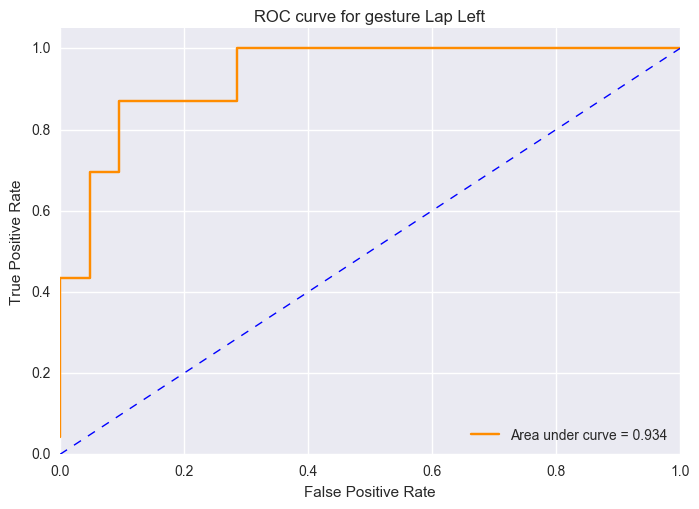

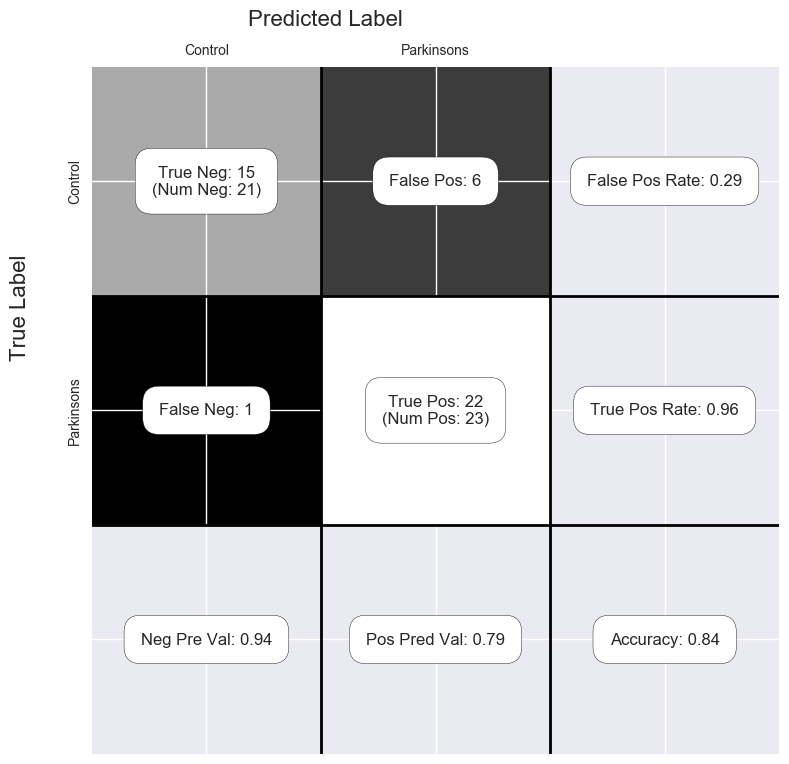

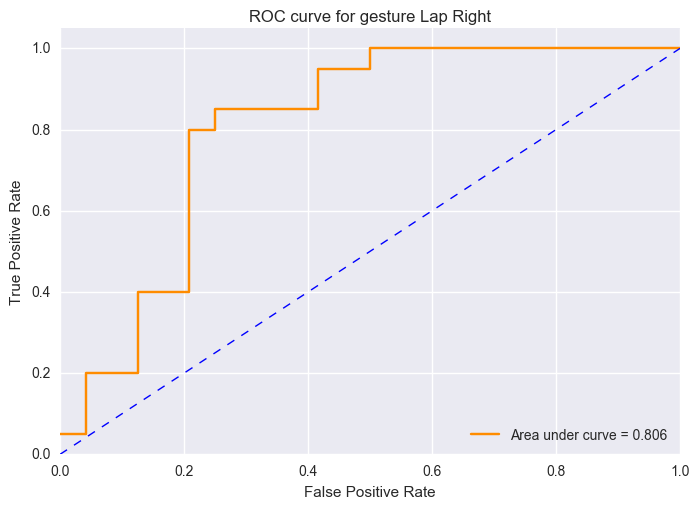

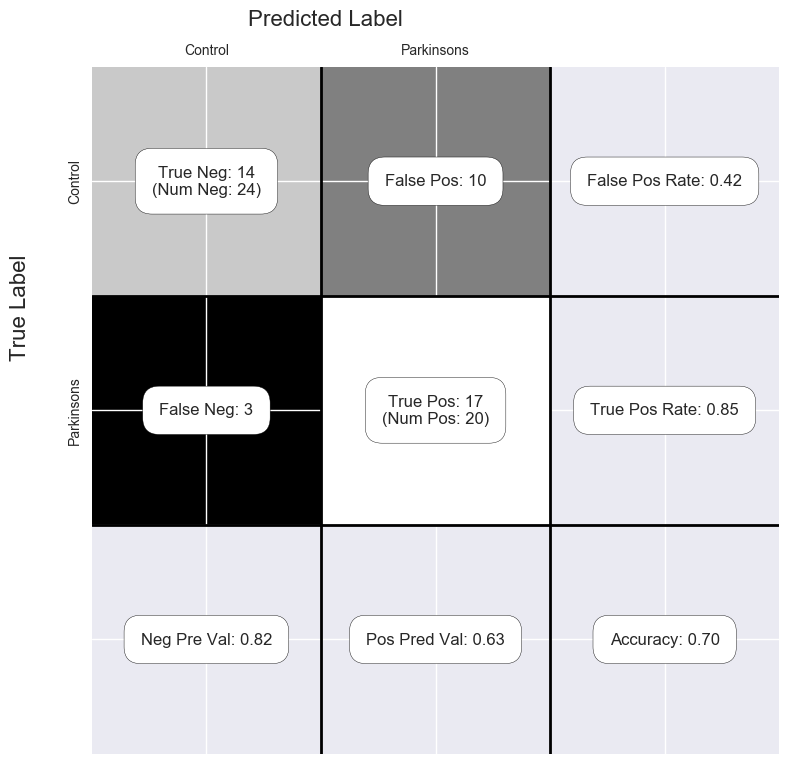

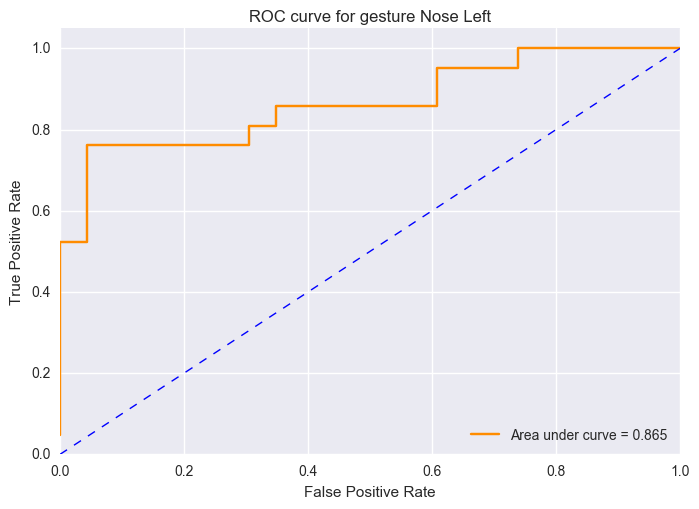

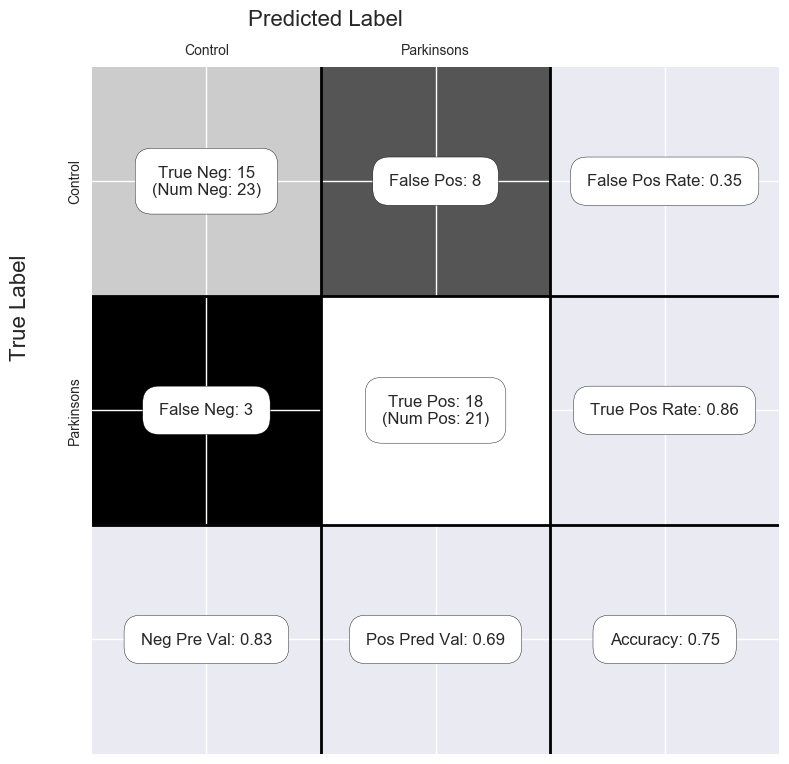

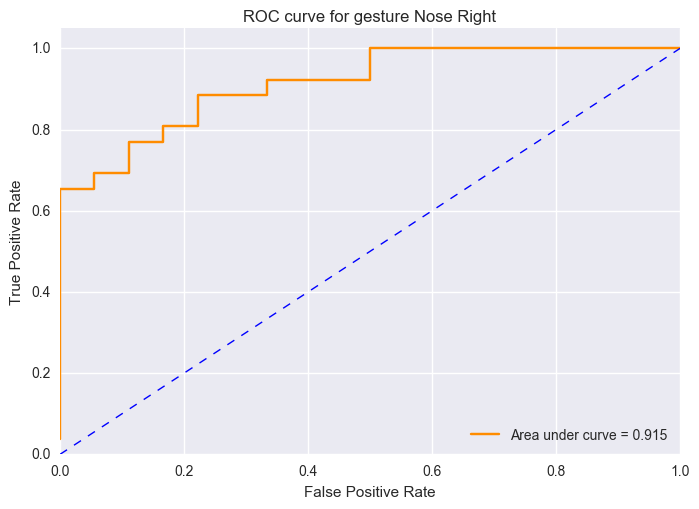

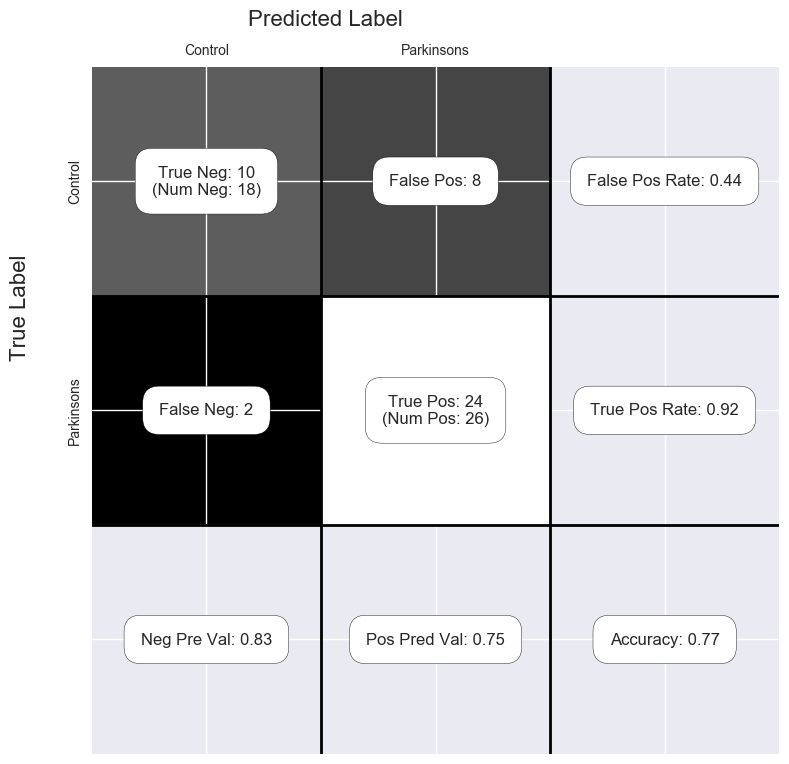

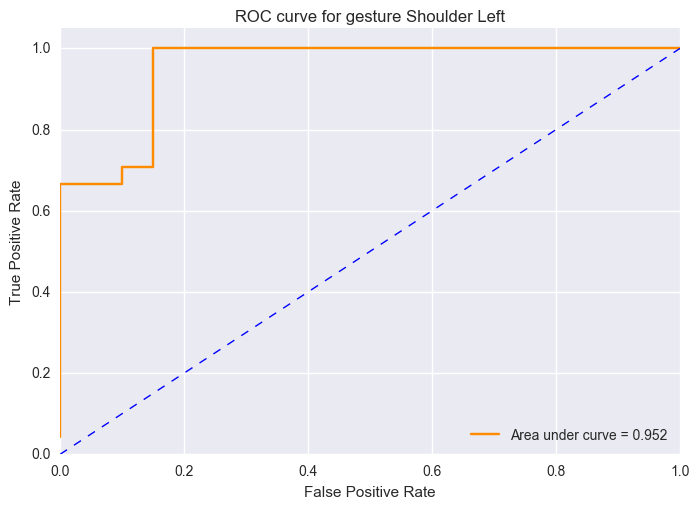

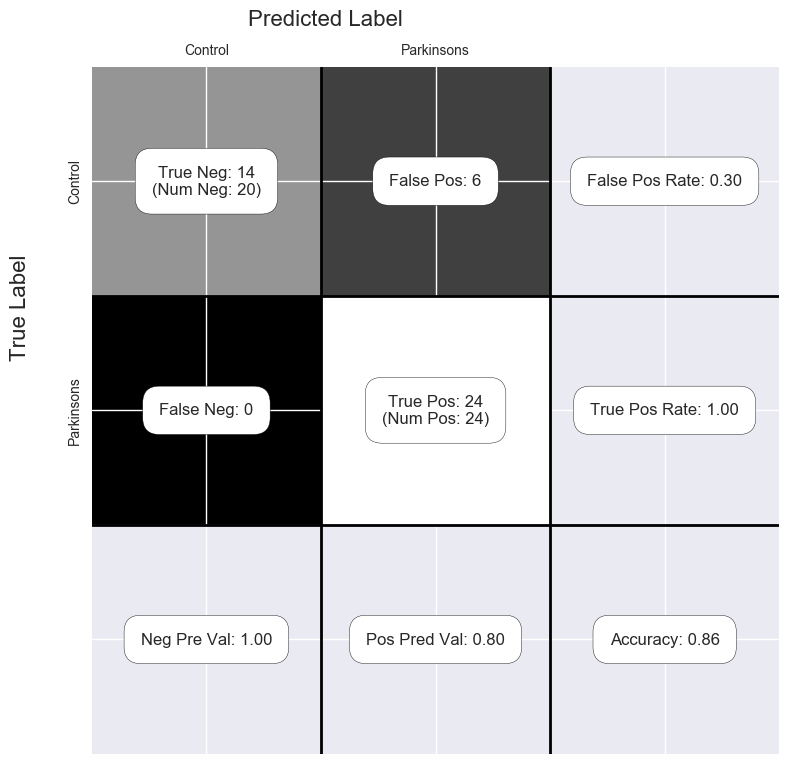

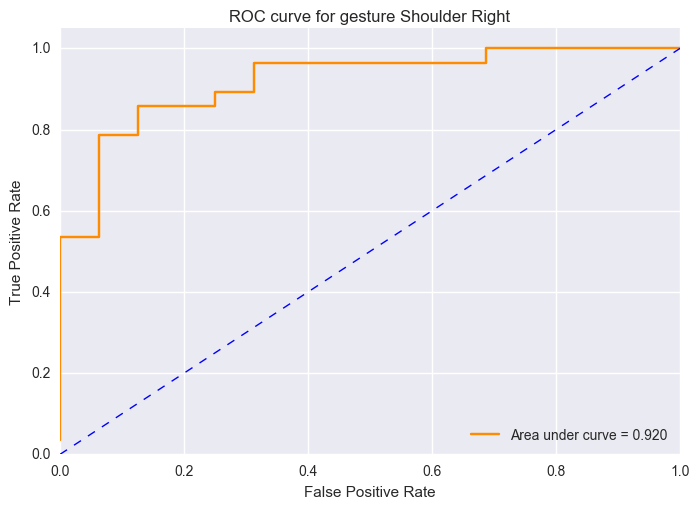

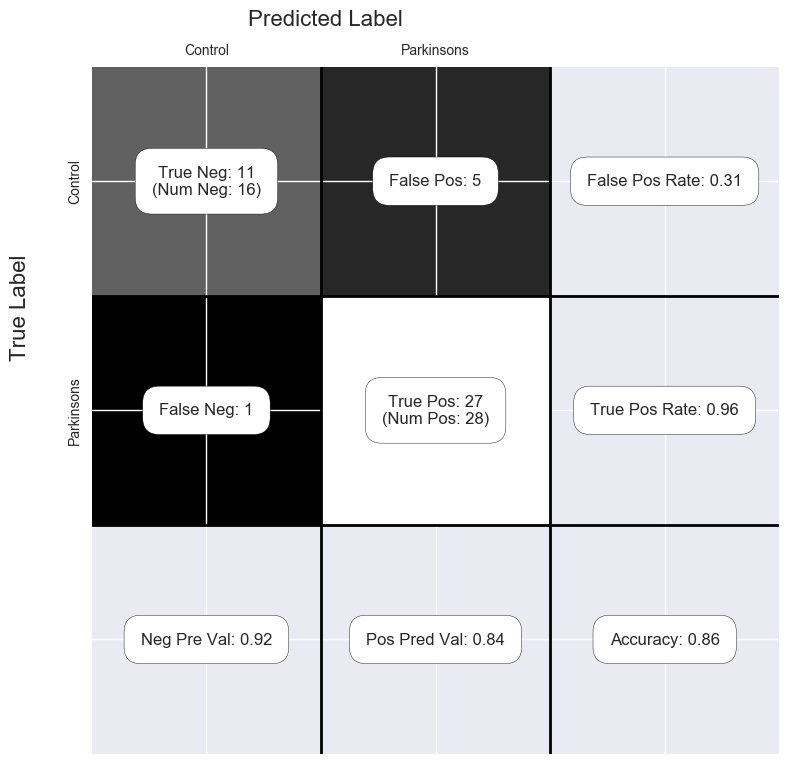

In [12]:
for i, gesture in enumerate(all_gesture_dfs):
    
    train, test = train_test_split(gesture, test_size = 0.2)
    X_train = train[optimal_feats[i]]
    y_train = train['datagroups']
    X_test = test[optimal_feats[i]]
    y_test = test['datagroups']
    
    # make a new pipeline for each gesture
    (my_pipe, my_lr) = make_pipe()

    # generate data for the ROC curve
    my_pipe.fit(X_train, y_train)
    roc_probabilities = my_pipe.predict_proba(X_test)[:, 1]

    # build the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, roc_probabilities, pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_auc = roc_auc_score(y_test, roc_probabilities)
    
    # plot the ROC curve
    nb.roc_on(fpr, tpr, roc_auc, gestures[i])
    
    # build and then display confusion matrix
    nb.build_cfm(roc_probabilities, y_test)
    

Instead of selecting an 'optimal' feature set, would regularization produce a more accurate model without restricting features?

The following code runs a 10-fold cross-validated regression on each unrestricted gesture feature set for values of C=0.1 to 0.25 (previous experimentation showing the highest accuracies for all these models falls in this range):

In [9]:
unrestricted_cv_scores = []

for i, gesture in enumerate(all_gesture_dfs):
    X, y = nb.create_predictor_set(gesture)
    highest_acc = [0,0]
    
    for reg_val in np.arange(0.1,0.25,0.01):
        (my_pipe, my_lr) = make_pipe(reg=reg_val)

        # evaluate model accuracy using k-fold cross validation
        cv_probabilities = cross_val_score(my_pipe, X, y, cv=num_folds)
        mean_acc = np.mean(cv_probabilities)
        if mean_acc > highest_acc[0]:
            highest_acc[0] = mean_acc
            highest_acc[1] = reg_val
    unrestricted_cv_scores.append(highest_acc)

# compare to models with restricted feature sets
best_reg_vals = [x[1] for x in unrestricted_cv_scores]
comparison_list = pd.DataFrame(
    {'Gesture': gestures,
     'Accuracy (selected features)': cv_selected_feats,
     'Best Accuracy (all features w. regularization)': [x[0] for x in unrestricted_cv_scores],
     'Best Regularization': best_reg_vals
    })

print "Cross-validation (k={})".format(num_folds)
comparison_list[[3,0,1,2]]

Cross-validation (k=10)


,Gesture,Accuracy (selected features),Best Accuracy (all features w. regularization),Best Regularization
0,Lap Left,0.861133,0.825127,0.10
1,Lap Right,0.888660,0.857416,0.18
2,Nose Left,0.829889,0.807538,0.11
3,Nose Right,0.829691,0.807124,0.10
4,Shoulder Left,0.861350,0.834651,0.11
5,Shoulder Right,0.848108,0.829475,0.18


In conclusion, for data of this type, feature selection followed by unregularized logistic regression performs better on each gesture than regularization applied to the full feature set. 

### Combining models to further improve accuracy:

In [10]:
def pair_model_accuracy(df1,df2,f1='',f2='',reg1=1000,reg2=1000):
    '''
    Merges two gesture datasets and returns cross-validated classification accuracy

    Input:
      m1, m2 - (object) two gesture data frames to be merged
      f1, f2 - (list) two feature lists - use all features if empty
      reg1, reg2 - (decimal) regularization parameters - 1000 if null
    Output:
      10-fold cross-validated accuracy of pair model
    '''
    # create a set of predictors for this pair of gestures
    first_X, y = nb.create_predictor_set(df1, f1)
    second_X = nb.create_predictor_set(df2, f2)[0]

    # age will be in both X data frames - remove one copy
    first_X.drop('age', axis=1, inplace=True)

    # merge X data frames
    pair_X = pd.concat([first_X, second_X], axis=1)

    # make a pipeline: regularization is the mean of the reg values
    (my_pipe, my_lr) = make_pipe(reg=(reg1+reg2)/2)

    # cross-validate and return mean accuracy
    return np.mean(cross_val_score(my_pipe, pair_X, y, cv=num_folds))


Using the helper function above, the loop below generates all pairwise model combinations, merges their data and performs two different regressions on each pair of gestures:
<ul>
<li> Leaving all features (except age, which would be duplicate) and applying the best value for regularization
<li> Restricting the feature set to only those selected by SFFS above, and applying no regularization
</ul>

Accuracy was estimated for both regression types using 10-fold cross-validation and for all 15 pairwise gesture combinations; the mean and standard deviation of each approach are calculated below.

In conclusion it appears that feature selecton (narrowly) outperforms regularization on this data, even when gestures are combined.

In [11]:
ar = []
af = []

for m1,m2 in it.combinations([0,1,2,3,4,5], 2):
    # for all pairwise gesture combinations
    # calculate CV-10 accuracy using regularization only
    ar.append(pair_model_accuracy(all_gesture_dfs[m1],all_gesture_dfs[m2],reg1=best_reg_vals[m1],reg2=best_reg_vals[m2]))
    # calculate CV-10 accuracy using feature selection only
    af.append(pair_model_accuracy(all_gesture_dfs[m1],all_gesture_dfs[m2],f1=optimal_feats[m1],f2=optimal_feats[m1]))

print "CV-10 accuracy using regularization only: {:.6f} (sd={:.6f})".format(np.mean(ar),np.std(ar))
print "CV-10 accuracy using feature selection only: {:.6f} (sd={:.6f})".format(np.mean(af),np.std(af))

CV-10 accuracy using regularization only: 0.821983 (sd=0.016663)
CV-10 accuracy using feature selection only: 0.830199 (sd=0.019885)
